<a href="https://colab.research.google.com/github/mobarakol/Grad-Cam/blob/main/gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Masks

In this notebook, we plot the [Grad-CAM](https://arxiv.org/abs/1610.02391) figures from the paper. For more info and other examples, have a look at [our README](https://github.com/ecs-vlc/fmix).

**Note**: The easiest way to use this is as a colab notebook, which allows you to dive in with no setup.

First, we load dependencies and some data from CIFAR-10:

In [1]:
!git clone https://github.com/ecs-vlc/FMix.git
%cd FMix

Cloning into 'FMix'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 251 (delta 13), reused 11 (delta 4), pack-reused 221
Receiving objects: 100% (251/251), 1.14 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (108/108), done.
/content/FMix


In [3]:
!pip install torchbearer

     |████████████████████████████████| 138 kB 5.2 MB/s 


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import models
from torchbearer import Trial
import cv2
import torch.nn.functional as F

inv_norm = transforms.Normalize((-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010), (1/0.2023, 1/0.1994, 1/0.2010))
valset = torchvision.datasets.CIFAR10(root='./data/cifar', train=False, download=True,
                                           transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),]))

valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=True, num_workers=8)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar/cifar-10-python.tar.gz to ./data/cifar


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model Wrapper

Next, we define a `ResNet` wrapper that will iterate up to some given block `k`:

In [5]:
class ResNet_CAM(nn.Module):
    def __init__(self, net, layer_k):
        super(ResNet_CAM, self).__init__()
        self.resnet = net
        convs = nn.Sequential(*list(net.children())[:-1])
        self.first_part_conv = convs[:layer_k]
        self.second_part_conv = convs[layer_k:]
        self.linear = nn.Sequential(*list(net.children())[-1:])
        
    def forward(self, x):
        x = self.first_part_conv(x)
        x.register_hook(self.activations_hook)
        x = self.second_part_conv(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = x.view((1, -1))
        x = self.linear(x)
        return x
    
    def activations_hook(self, grad):
        self.gradients = grad
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.first_part_conv(x)

## Grad-CAM

Now for the Grad-CAM code, adapted from [implementing-grad-cam-in-pytorch](https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82):

In [6]:
def superimpose_heatmap(heatmap, img):
    resized_heatmap = cv2.resize(heatmap.numpy(), (img.shape[2], img.shape[3]))
    resized_heatmap = np.uint8(255 * resized_heatmap)
    resized_heatmap = cv2.applyColorMap(resized_heatmap, cv2.COLORMAP_JET)
    superimposed_img = torch.Tensor(cv2.cvtColor(resized_heatmap, cv2.COLOR_BGR2RGB)) * 0.006 + inv_norm(img[0]).permute(1,2,0)
    
    return superimposed_img

def get_grad_cam(net, img):
    net.eval()
    pred = net(img)
    pred[:,pred.argmax(dim=1)].backward()
    gradients = net.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = net.get_activations(img).detach()
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    
    return torch.Tensor(superimpose_heatmap(heatmap, img).permute(2,0,1))

## Models From `torch.hub`

Next, we load in the models from `torch.hub`

In [7]:
baseline_net = torch.hub.load('ecs-vlc/FMix:master', 'preact_resnet18_cifar10_baseline', pretrained=True)

fmix_net = torch.hub.load('ecs-vlc/FMix:master', 'preact_resnet18_cifar10_fmix', pretrained=True)

mixup_net = torch.hub.load('ecs-vlc/FMix:master', 'preact_resnet18_cifar10_mixup', pretrained=True)

fmix_plus_net = torch.hub.load('ecs-vlc/FMix:master', 'preact_resnet18_cifar10_fmixplusmixup', pretrained=True)

Downloading: "https://github.com/ecs-vlc/FMix/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "http://marc.ecs.soton.ac.uk/pytorch-models/cifar10/preact-resnet18/cifar10_preact_resnet18_baseline_0.pt" to /root/.cache/torch/hub/checkpoints/cifar10_preact_resnet18_baseline_0.pt


  0%|          | 0.00/42.7M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/ecs-vlc_FMix_master
Downloading: "http://marc.ecs.soton.ac.uk/pytorch-models/cifar10/preact-resnet18/cifar10_preact_resnet18_fmix_0.pt" to /root/.cache/torch/hub/checkpoints/cifar10_preact_resnet18_fmix_0.pt


  0%|          | 0.00/42.7M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/ecs-vlc_FMix_master
Downloading: "http://marc.ecs.soton.ac.uk/pytorch-models/cifar10/preact-resnet18/cifar10_preact_resnet18_mixup_0.pt" to /root/.cache/torch/hub/checkpoints/cifar10_preact_resnet18_mixup_0.pt


  0%|          | 0.00/42.7M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/ecs-vlc_FMix_master
Downloading: "http://marc.ecs.soton.ac.uk/pytorch-models/cifar10/preact-resnet18/cifar10_preact_resnet18_fmixplusmixup_0.pt" to /root/.cache/torch/hub/checkpoints/cifar10_preact_resnet18_fmixplusmixup_0.pt


  0%|          | 0.00/42.7M [00:00<?, ?B/s]

## Plots

Finally, generate and save the Grad-CAM plots:

In [8]:
layer_k = 4
n_imgs = 10

baseline_cam_net = ResNet_CAM(baseline_net, layer_k)
fmix_cam_net = ResNet_CAM(fmix_net, layer_k)
mixup_cam_net = ResNet_CAM(mixup_net, layer_k)
fmix_plus_cam_net = ResNet_CAM(fmix_plus_net, layer_k)

imgs = torch.Tensor(5, n_imgs, 3, 32, 32)
it = iter(valloader)
for i in range(0,n_imgs):
    img, _ = next(it)
    imgs[0][i] = inv_norm(img[0])
    imgs[1][i] = get_grad_cam(baseline_cam_net, img)
    imgs[2][i] = get_grad_cam(mixup_cam_net, img)
    imgs[3][i] = get_grad_cam(fmix_cam_net, img)
    imgs[4][i] = get_grad_cam(fmix_plus_cam_net, img)

torchvision.utils.save_image(imgs.view(-1, 3, 32, 32), "gradcam_at_layer" + str(layer_k) + ".png",nrow=n_imgs, pad_value=1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


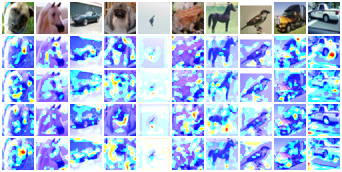

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
#plt.imshow(Image.open('gradcam_at_layer4.png'))
Image.open('gradcam_at_layer4.png')